In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

PREFIX='a video of '

In [4]:
events = [
        "Riding",
        "Fighting",
        "Playing",
        "Running",
        'Lying',
        "Chasing",
        "Jumping",
        "Falling",
        "Guiding",
        "Stealing",
        "Littering",
        "Tripping",
        "Pickpockering",
    ]
description = [
        "a person riding a bicycle on the street",  # Added context
        "multiple people engaged in a physical fight",  # More specific than "fighting"
        "a group of people playing a sport together",  # Added "sport" for visual clarity
        "a person running",  # Added context
        "a person lying motionless on the ground",  # "Motionless" helps distinguish from falling
        "a person aggressively chasing another person",  # "Aggressively" adds distinction
        "a person jumping high in the air with both feet",  # More specific than just "jumping"
        "a person accidentally falling to the ground",  # "Accidentally" helps distinguish
        "a person gently guiding another person by the arm",  # Added detail
        "a person stealing other person",  # More specific than "stealing"
        "a person deliberately throwing garbage on the ground",  # "Deliberately" adds clarity
        "a person tripping over an obstacle",  # More descriptive
        "a person pickpocketing a wallet from someone's pocket",  # Very specific
    ]

In [5]:
description=[PREFIX+desc for desc in description]
events_description = {event: desc for event, desc in zip(events, description)}
normal_class = PREFIX + "a normal view (persons walking or standing)"

all_classes =  description+[normal_class]
class_to_idx = {cls: idx for idx, cls in enumerate(all_classes)}
# Example: {"a normal view...": 0, "a person riding...": 1, ...}
num_classes = len(all_classes)  # 14
cm = np.zeros((num_classes, num_classes), dtype=int)
framesgt = np.load("/home/ubuntu/Database/ALL/GT/gt_ALL.npz")

<class 'numpy.ndarray'>
a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a person riding a bicycle on the street a video of a normal view (persons walking or standing)

a video of a 

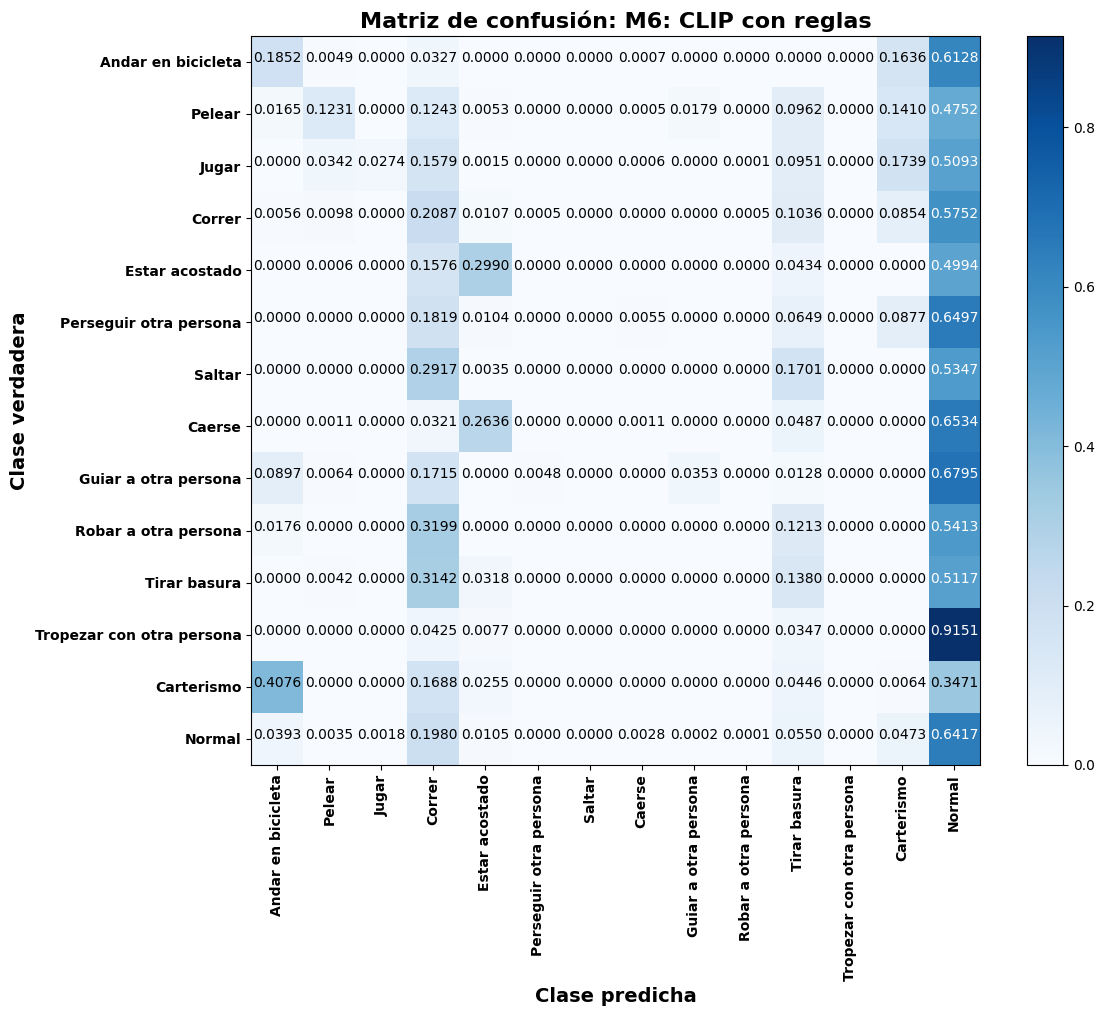

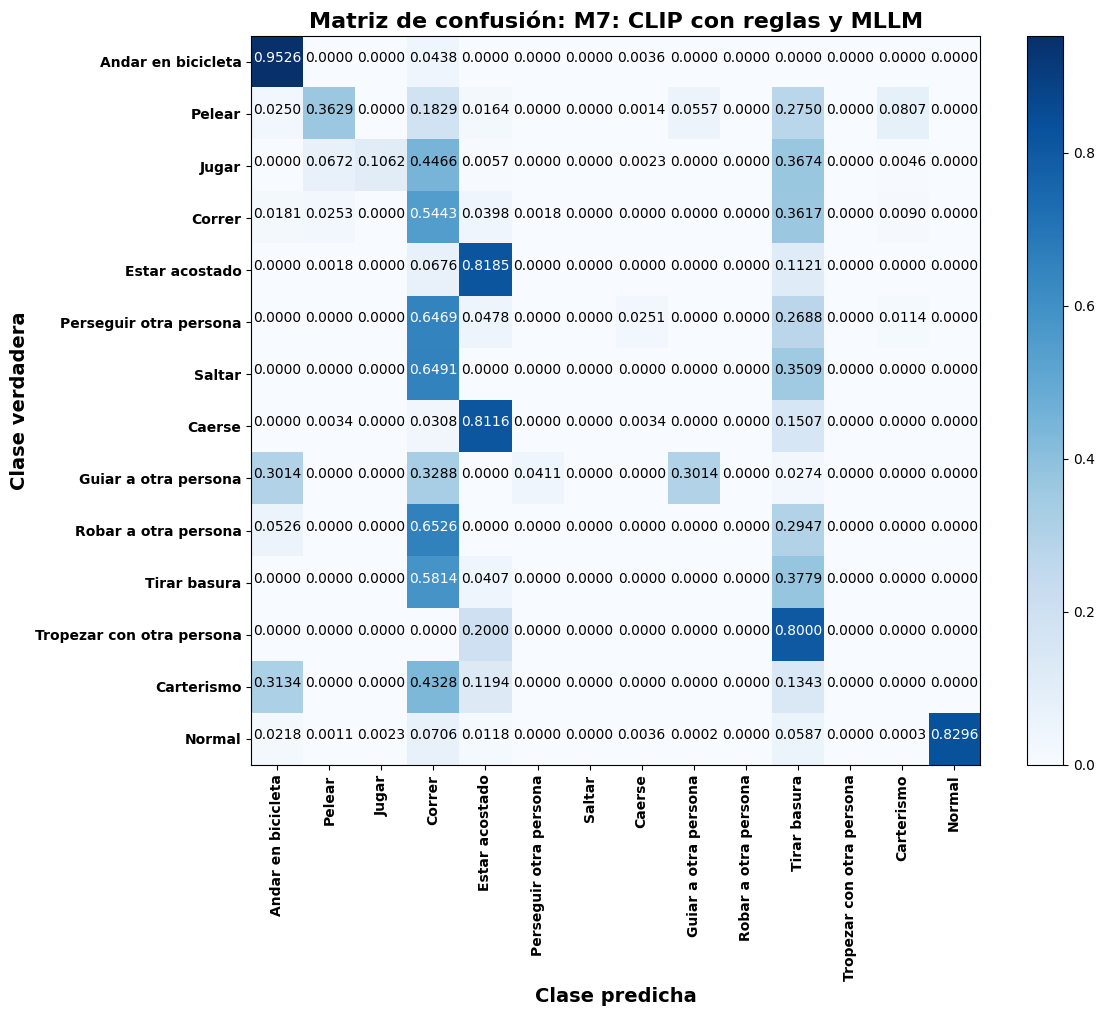

In [6]:

mode_names = {
        0: "M6: CLIP con reglas",
        1: "M7: CLIP con reglas y MLLM",
}

rute="/home/ubuntu/Database/ALL/Videos"
rute_stored='/home/ubuntu/Tesis/Storage/'
modes=[0,1]
usage='CLIP'
for mode in modes:
    cm = np.zeros((num_classes, num_classes), dtype=int)
    detections=0
    for folder_number in range(len(events)):
        folder=f"{rute}/{events[folder_number]}/"
        files= os.listdir(folder)
        for file in files:
            stored_file=file.split('.')[0]
            desc=events_description[events[folder_number]]
            info_stored=np.load(f"{rute_stored}{stored_file}_{usage}_{mode}_{desc}.npy", allow_pickle=True)
            frames_number=info_stored[0]
            predicted_events=info_stored[1]
            prompts=info_stored[2]
            event= events_description[events[folder_number]]
            frames= framesgt[stored_file]
            frames = np.append(frames, frames[-1])
            prompts = [prompt.lower().split('.')[0] for prompt in prompts]
            # Save frames_number, predicted_events, and prompts into a numpy array
            for i in range(len(predicted_events)):
                detections += 1
                # Get ground truth
                is_anomaly = frames[frames_number[i] - 1]  # 0 or 1
                # Determine true class using EVENT when anomaly exists
                true_class = event if is_anomaly == 1 else normal_class
                pred_class = predicted_events[i]
                if prompts[i] == "" and (mode==0 or mode==2):
                    pass
                elif prompts[i] == "yes":
                    pass
                elif prompts[i] == "no":
                    continue
                else:
                    if true_class == pred_class:
                        pass
                    else:
                        print(f'{true_class} {pred_class}\n')
                        continue
                # Get predicted class
                # Convert to indices (skip if class not recognized)
                true_idx = class_to_idx.get(true_class, -1)
                pred_idx = class_to_idx.get(pred_class, -1)
                
                if true_idx != -1 and pred_idx != -1:
                    cm[true_idx, pred_idx] += 1
    plt.figure(figsize=(12, 10))
    print(type(cm))
    #cm_normalized=cm.copy()
    #cm = cm / cm.sum(axis=1, keepdims=True)
    cm = cm / cm.sum(axis=1, keepdims=True)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Matriz de confusión: {mode_names[mode]}", fontsize=16, fontweight='bold')
    plt.xlabel("Clase predicha", fontsize=14, fontweight='bold')
    plt.ylabel("Clase verdadera", fontsize=14, fontweight='bold')
    plt.colorbar()
    # Replace class names with the ones from the replace list
    replace = [
        "Andar en bicicleta",
        "Pelear",
        "Jugar",
        "Correr",
        'Estar acostado',
        "Perseguir otra persona",
        "Saltar",
        "Caerse",
        "Guiar a otra persona",
        "Robar a otra persona",
        "Tirar basura",
        "Tropezar con otra persona",
        "Carterismo",
        'Normal',
    ]
    updated_classes = replace
    tick_marks = np.arange(num_classes)   
    plt.xticks(tick_marks, updated_classes, rotation=90, fontweight='bold')  # Rotate x-axis labels for better visibility
    plt.yticks(tick_marks, updated_classes, fontweight='bold')   # Annotate the matrix with the values
    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.4f}",
                            horizontalalignment="center",
                            color="white" if cm[i, j] > thresh else "black")   
    plt.tight_layout()
    #plt.savefig(f"CM/confusion_matrix_{usage}_{mode}.png", bbox_inches='tight')
plt.show()
